In [1]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time
import threshold_BGLSS
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc as matplotlibrc


matplotlibrc('text', usetex=True)
matplotlibrc('font', family='serif')



fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
importlib.reload(threshold_BGLSS)
from threshold_BGLSS import *

## Define the PDE

In [3]:
def parametric_advection_rhs(u, t, params):
    k,c,dx = params
    art_visc = 1e-2
    cond1=c>0.0
    cond2=c<=0.0
    rhs = 0.0*u
    rhs[cond2] = -c[cond2]*(np.roll(u,-1)[cond2]-u[cond2])/dx
    rhs[cond1] = -c[cond1]*(u[cond1] - np.roll(u,1)[cond1])/dx
    return rhs

## Solve the PDE

In [4]:
# Set size of grid
n = 256
m = 256
L = 20

# Set up grid
x = np.linspace(-5,5,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x)**2/2**2)
c = np.zeros(x.shape)
c[x<0] =-1.0
c[x>=0] =1.0

# Solve with time dependent uu_x term
params = (k, c,dx)
u = odeint(parametric_advection_rhs, u0, t, args=(params,)).T

u_x_true = np.copy(c)


/tmp/ipykernel_138018/2232658284.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(X, T, u.T, cmap=cm.coolwarm)


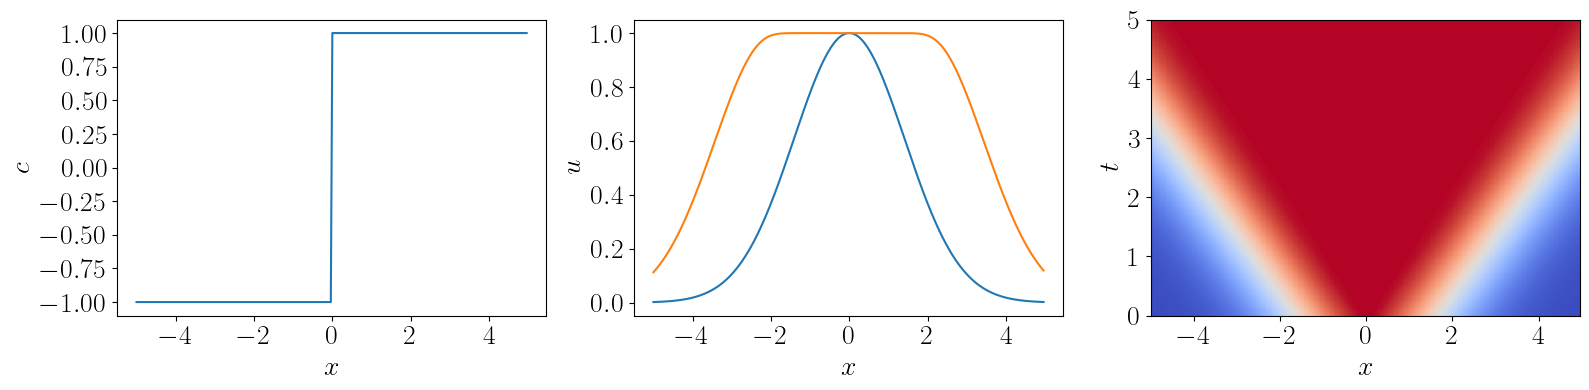

In [31]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)
subplot(1,3,1)
plot(x, c, label=r'$u(x,t=0)$')
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel(r'$x$', fontsize = fontsize)
ylabel(r'$c$', fontsize = fontsize)
#legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
subplot(1,3,2)
plot(x, u[:,0], label=r'$u(x,t=0)$')
plot(x, u[:,102], label=r'$u(x,t=2.0)$')
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel(r'$x$', fontsize = fontsize)
ylabel(r'$u$', fontsize = fontsize)
subplot(1,3,3)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel(r'$x$', fontsize = fontsize)
ylabel(r'$t$', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])
plt.tight_layout()
plt.savefig('advection_sol.png')

## Build the Regression Model

In [6]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')

In [7]:
Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(Ut[n*np.arange(m)+j]) for j in range(n)]
Xs = Theta_grouped
ys = Ut_grouped

In [8]:
xi_true = np.zeros((len(rhs_des),m))
i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
xi_true[i_u_x,:] = u_x_true

In [9]:
xi, lam, loss, path, coef, remain = thresholdBGLSS_combined(Theta_grouped, Ut_grouped, niter = 600, burnin = 100, threshold1 = 0.02, threshold2 = 0.08)

0
20
Update:
0
Lambda2:
0.49445337636177555

Update:
1
Lambda2:
0.2624947147020039

Update:
2
Lambda2:
0.1673967506911926

Update:
3
Lambda2:
0.12031676512754493

Update:
4
Lambda2:
0.09409040940285544

Update:
5
Lambda2:
0.0780388657357479

Update:
6
Lambda2:
0.06764062226753521

Update:
7
Lambda2:
0.06090556443539234

Update:
8
Lambda2:
0.05624160385713735

Update:
9
Lambda2:
0.05269981863961074

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:206: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), loss_normalize)
/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:23: RuntimeWarning: invalid value encountered in true_divide
  rate = np.sum(variance, axis=1)/np.sum(mean**2, axis=1)


GE: 
[0.10749255        nan 0.04568525        nan 0.0020757         nan
        nan 0.17193019        nan        nan        nan 0.30332273
 0.28884201        nan        nan 0.0913029         nan        nan
        nan        nan]
[4]
0
1
Update:
0
Lambda2:
0.06070675461245794

Update:
1
Lambda2:
0.013823651690870235

Update:
2
Lambda2:
0.006605155508343621

Update:
3
Lambda2:
0.004573237314549394

Update:
4
Lambda2:
0.0037306513521888542

Update:
5
Lambda2:
0.003407557830897875

Update:
6
Lambda2:
0.0032474787724794374

Update:
7
Lambda2:
0.00318509856191669

Update:
8
Lambda2:
0.0031230574349938875

Update:
9
Lambda2:
0.0031386553304119315

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


In [10]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi_sgtr = Xi[np.argmin(Losses)]

/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:601: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:571: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


(256, 20)
[4]


/tmp/ipykernel_138018/1646234553.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(x,1.0/diag(Hess))


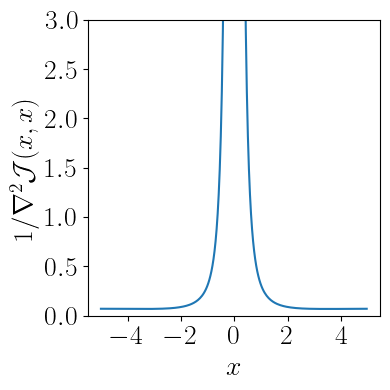

In [18]:
print(Theta_grouped[0].shape)
print(remain)
Theta_remain = Theta[:,remain].reshape(m,n)#First dim space, second dim time
Hess = np.matmul(Theta_remain.T,Theta_remain)

pylab.rcParams['figure.figsize'] = (4, 4)
plt.plot(x,1.0/diag(Hess))

#title('Advection equation', fontsize = 16)
xlabel(r'$x$', fontsize = fontsize)
ylabel(r'$1/\nabla^2\mathcal{J}(x,x)$', fontsize = fontsize)
#legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
ylim(0,3)
plt.tight_layout()
plt.savefig('UQ_hess.png')


MSE:  0.19514123677888706


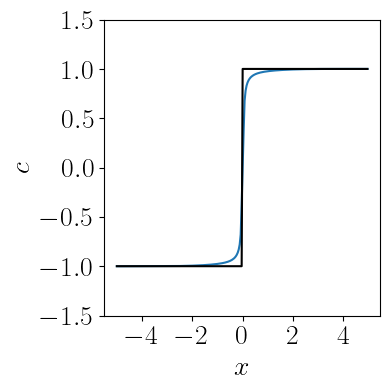

In [19]:
pylab.rcParams['figure.figsize'] = (4, 4)
for j in range(xi_sgtr.shape[0]): 
    if np.linalg.norm(xi_sgtr[j,:]) > 10**-10:
        plot(x,-xi_sgtr[j,:], label = rhs_des[j])

#title('Advection equation', fontsize = 16)
xlabel(r'$x$', fontsize = fontsize)
ylabel(r'$c$', fontsize = fontsize)
#legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
mse_clean_sgtr = Norm(xi_sgtr-xi_true)**2/(m*len(rhs_des))
ylim(-1.5,1.5)
plt.plot(x,c,'-k')
print('MSE: ', mse_clean_sgtr)
plt.tight_layout()
plt.savefig('advection_sgtr.png')

In [13]:
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(n)] for j in range(D)]

Xi_lasso,Lam_lasso,Losses_lasso,Histories_Lasso = TrainGroupLasso(Theta_grouped, Ut_grouped, groups)
xi_lasso = Xi_lasso[np.argmin(Losses_lasso)]

/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:456: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:436: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  z[nz_coords,j] = np.linalg.lstsq(As[j][:, nz_coords], bs[j])[0][:,0]


MSE:  868.1113686905865


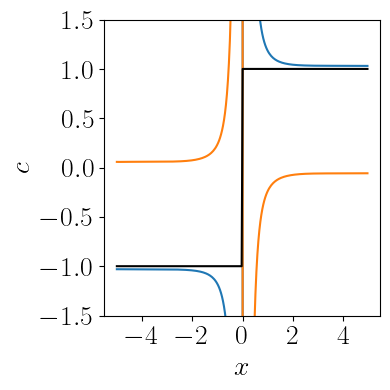

In [29]:
pylab.rcParams['figure.figsize'] = (4, 4)
for j in range(xi_lasso.shape[0]): 
    if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
        plot(x,-xi_lasso[j,:], label = rhs_des[j])
plt.plot(x,c,'-k')
#title('Advection Equation Coefficients via Group Lasso', fontsize = 16)
xlabel(r'$x$', fontsize = fontsize)
ylabel(r'$c$', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
#legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
ax = plt.gca()
ax.set_ylim(-1.5,1.5)
mse_clean_gl = Norm(xi_lasso-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_gl)
plt.tight_layout()
plt.savefig('advection_lasso.png')

In [15]:
print(coef[7,20])

1.0000281470374204


/tmp/ipykernel_138018/2271764248.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coef[7, :], color = 'r', kde=True)


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

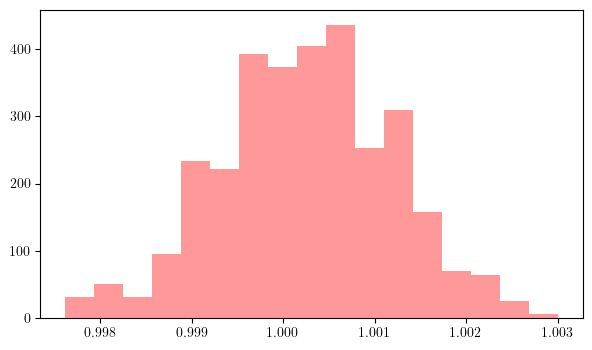

In [16]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
sns.distplot(coef[7, :], color = 'r', kde=True)
fig.savefig("hist_KS.png", dpi=200)

In [ ]:
np.median(coef[7, :])

In [ ]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
ci, mean = bootstrapMedian(coef[7, :], show_hist = True, bins = 20)
fig.savefig("hist_bootstrap_KS.png", dpi=200)
print(ci)
print(mean)

In [20]:
ci, means = getCI(coef, m)

In [21]:
xi.shape

(1, 256)

In [22]:
d = len(rhs_des)

In [23]:
std = np.std(coef, axis=1, ddof=1).reshape(m, xi.shape[0]).T

In [24]:
np.mean(std[0,:])

0.007469434792030106

In [25]:
np.mean(-ci[0][0,:]+ci[1][0,:])

0.0017703229145642015

MSE:  0.19514088589221684


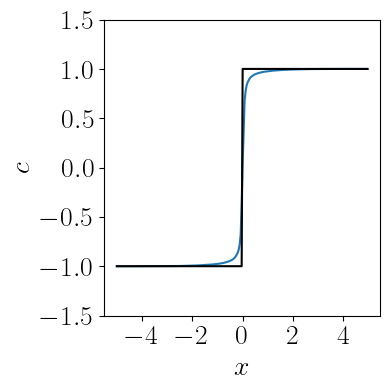

In [30]:
xi_bglss = np.zeros((d, m))

pylab.rcParams['figure.figsize'] = (4, 4)
fig, ax = plt.subplots()
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(x,-xi[j,:], label = r'$'+rhs_des[remain[j]]+'$')
        #fill_between(x, -(xi[j,:]-10*std[j, :]), -(xi[j,:]+10*std[j, :]), alpha=0.4)
        xi_bglss[remain[j], :] = xi[j,:]
#for j in range(xi_sgtr.shape[0]): 
#    if np.linalg.norm(xi_sgtr[j,:]) > 10**-10:
#        plot(x,-xi_sgtr[j,:], label = rhs_des[j])

ax=pylab.gca()
ax.set_ylim(-1.5,1.5)
#title('Advection Equation Coefficients', fontsize = 16)
xlabel(r'$x$', fontsize = fontsize)
ylabel(r'$c$', fontsize = fontsize)
#legend(loc='center left', fontsize = 14)
plt.plot(x,c,'-k')
mse_clean_tbglss = Norm(xi_bglss-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_tbglss)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
plt.tight_layout()
plt.savefig('advection_sbglss.png')

(256, 256)
(256, 256)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


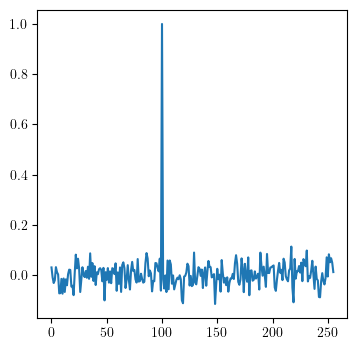

In [27]:
Mcoef=np.mean(coef,axis=1)
ngrid,nsample=coef.shape
Pcoef=coef-Mcoef.reshape(-1,1)
Covcoef = np.matmul(Pcoef,Pcoef.T)/nsample
print(Covcoef.shape)

#plt.scatter(coef[129,:],coef[200,:],marker='s')
#plt.scatter(coef[151,:]-np.mean(coef[151,:]),coef[150,:]-np.mean(coef[150,:]),marker='^')
#plt.scatter(coef[140,:]-np.mean(coef[140,:]),coef[150,:]-np.mean(coef[150,:]),marker='^')
#plt.scatter(coef[129,:],coef[130,:],marker='o')
#plt.xlim(-0.02,0.02)
#plt.ylim(-0.02,0.02)
#plt.show()
Diagcoef=np.diag(Covcoef).reshape(-1,1)
Normcoef=np.matmul(Diagcoef,Diagcoef.T)
print(Normcoef.shape)
Corrcoef=Covcoef/Normcoef**.5
print(diag(Corrcoef))
plt.plot(Corrcoef[100,:])
plt.show()





In [ ]:
un = u + 0.0001*np.std(u)*np.random.randn(n,m)

In [ ]:
# Build linear systems
wx = 10
wt = 10

deg_x = 6
deg_t = 4

Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = deg_x, deg_t = deg_t, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [ ]:
# Group by location
Thetan_grouped = [real(Thetan[n2*np.arange(m2)+j,:]) for j in range(n2)]
Utn_grouped = [real(Utn[n2*np.arange(m2)+j]) for j in range(n2)]

In [ ]:
xi_n, lam_n, loss_n, path_n, coef_n, remain_n = thresholdBGLSS(Thetan_grouped, Utn_grouped, niter = 600, burnin = 100, threshold = 10**-2)

In [ ]:
remain_n

In [ ]:
ci_n, means_n = getCI(coef_n, m2)

In [ ]:
xi_bglss = np.zeros((d, m2))

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[remain_n[j]])
        fill_between(range(len(xi_n[j,:])), ci_n[1][j, :], ci_n[0][j, :], alpha=0.4)
        xi_bglss[remain_n[j], :] = xi_n[j,:]

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_tbglss = Norm(xi_bglss-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))
print('MSE: ', mse_noise_tbglss)

In [ ]:
groupError(coef_n, m2)

In [ ]:
totalError(coef_n)

In [ ]:
X_n1, Lam_n1, Losses_n1, Coef_n1, Remain_n1, TE_n1, Threshold_n1 = TrainBGLSS_findt1(Thetan_grouped, Utn_grouped, num_threshold = 21, max_threshold = 0.1, min_threshold = 0, niter = 600, burnin = 100)

In [ ]:
MSEs_n1 = getMSEs(X_n1, Remain_n1, xi_true[:,wt:-wt])

In [ ]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
ax.plot(Threshold_n1, Losses_n1, label = 'threshold1 = 0')
xlabel('Threshold', fontsize = fontsize)
ylabel('Losses', fontsize = fontsize)
fig.savefig("Losses-1.png", dpi=200)

In [ ]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(Threshold_n1, TE_n1, label = 'threshold1 = 0')
xlabel('Threshold', fontsize = fontsize)
ylabel('Total Error Bar', fontsize = fontsize)
pylab.show()
fig.savefig("TE-1.png", dpi=200)

In [ ]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(Threshold_n1, MSEs_n1, label = 'threshold1 = 0')
xlabel('Threshold', fontsize = fontsize)
ylabel('MSE', fontsize = fontsize)
pylab.show()
fig.savefig("MSE-1.png", dpi=200)

In [ ]:
X_n2, Lam_n2, Losses_n2, Coef_n2, Remain_n2, TE_n2, Threshold_n2 = TrainBGLSS_findt2(Thetan_grouped, Utn_grouped, threshold1 = 0, num_threshold = 21, max_threshold = 0.23, min_threshold = 0.03, niter = 600, burnin = 100)

In [ ]:
X_n3, Lam_n3, Losses_n3, Coef_n3, Remain_n3, TE_n3, Threshold_n3 = TrainBGLSS_findt2(Thetan_grouped, Utn_grouped, threshold1 = 0.03, num_threshold = 21, max_threshold = 0.22, min_threshold = 0.02, niter = 600, burnin = 100)

In [ ]:
X_n4, Lam_n4, Losses_n4, Coef_n4, Remain_n4, TE_n4, Threshold_n4 = TrainBGLSS_findt2(Thetan_grouped, Utn_grouped, threshold1 = 0.07, num_threshold = 21, max_threshold = 0.22, min_threshold = 0.02, niter = 600, burnin = 100)

In [ ]:
MSEs_n2 = getMSEs(X_n2, Remain_n2, xi_true[:,wt:-wt])
MSEs_n3 = getMSEs(X_n3, Remain_n3, xi_true[:,wt:-wt])
MSEs_n4 = getMSEs(X_n4, Remain_n4, xi_true[:,wt:-wt])

In [ ]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
plot(Threshold_n2, Losses_n2, label = 'threshold1 = 0')
plot(Threshold_n3, Losses_n3, label = 'threshold1 = 0.03')
plot(Threshold_n4, Losses_n4, label = 'threshold1 = 0.07')
xlabel('Threshold', fontsize = fontsize)
ylabel('Loss', fontsize = fontsize)
legend( bbox_to_anchor=(1, 0.5), fontsize = 12)
pylab.show()
fig.savefig("Loss-2.png", dpi=200)

In [ ]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
plot(Threshold_n2, MSEs_n2, label = 'threshold1 = 0')
plot(Threshold_n3, MSEs_n3, label = 'threshold1 = 0.03')
plot(Threshold_n4, MSEs_n4, label = 'threshold1 = 0.07')
xlabel('Threshold', fontsize = fontsize)
ylabel('MSE', fontsize = fontsize)
legend( bbox_to_anchor=(1, 0.5), fontsize = 12)
pylab.show()
fig.savefig("MSE-2.png", dpi=200)

In [ ]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
plot(Threshold_n2, TE_n2, label = 'threshold1 = 0')
plot(Threshold_n3, TE_n3, label = 'threshold1 = 0.03')
plot(Threshold_n4, TE_n4, label = 'threshold1 = 0.07')
xlabel('Threshold', fontsize = fontsize)
ylabel('Total Error Bar', fontsize = fontsize)
legend( bbox_to_anchor=(1, 0.5), fontsize = 12)
pylab.show()
fig.savefig("MSE-2.png", dpi=200)

In [ ]:
xi_n2 = X_n2[-1]
remain_n2 = Remain_n2[-1]
xi_bglss = np.zeros((d, m2))

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n2.shape[0]): 
    if np.linalg.norm(xi_n2[j,:]) > 10**-10:
        plot(xi_n2[j,:], label = rhs_des[remain_n2[j]])
#         fill_between(range(len(xi_n[j,:])), ci_n[1][j, :], ci_n[0][j, :], alpha=0.4)
        xi_bglss[remain_n2[j], :] = xi_n2[j,:]

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_tbglss = Norm(xi_bglss-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))
print('MSE: ', mse_noise_tbglss)

In [ ]:
xi_tb_n, lam_tb_n, loss_tb_n, path_tb_n, coef_tb_n, remain_tb_n = thresholdBGLSS_combined(Thetan_grouped, Utn_grouped, niter = 1100, burnin = 100, threshold1 = 0.1, threshold2 = 0.05)

In [ ]:
std_tb_n = np.std(coef_tb_n, axis=1, ddof=1).reshape(m2,xi_tb_n.shape[0]).T

In [ ]:
xi_bglss_n = np.zeros((d, m2))

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_tb_n.shape[0]): 
    if np.linalg.norm(xi_tb_n[j,:]) > 10**-10:
        plot(xi_tb_n[j,:], label = rhs_des[remain_tb_n[j]])
        fill_between(range(len(xi_tb_n[j,:])), xi_tb_n[j,:]-1*std_tb_n[j, :], xi_tb_n[j,:]+1*std_tb_n[j, :], alpha=0.4)
        xi_bglss_n[remain_tb_n[j], :] = xi_tb_n[j,:]

title('KS Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_tbglss = Norm(xi_bglss_n-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))
print('MSE: ', mse_noise_tbglss)

In [ ]:
Xi_sgtr_n,Tol_sgtr_n,Losses_sgtr_n = TrainSGTRidge(Thetan_grouped, Utn_grouped)
xi_sgtr_n = Xi_sgtr_n[np.argmin(Losses_sgtr_n)]

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_sgtr_n.shape[0]): 
    if np.linalg.norm(xi_sgtr_n[j,:]) > 10**-10:
        plot(xi_sgtr_n[j,:], label = rhs_des[j])

title('KS Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_sgtr_n-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))

print('MSE: ', mse_noise_sgtr)

In [ ]:
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(n2)] for j in range(D)]
Xi_lasso_n,Lam_lasso_n,Losses_lasso_n,Histories_Lasso_n  = TrainGroupLasso(Thetan_grouped, Utn_grouped, groups)
xi_lasso_n = Xi_lasso_n[np.argmin(Losses_lasso_n)]

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso_n.shape[0]): 
    if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
        plot(xi_lasso_n[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_gl = Norm(xi_lasso_n-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))
print('MSE: ', mse_noise_gl)

In [ ]:
un = u + 0.05*np.std(u)*np.random.randn(n,m)

In [ ]:
# Build linear systems
wx = 10  
wt = 10  

deg_x = 6
deg_t = 4
 
Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = deg_x, deg_t = deg_t, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [ ]:
# Group by location
Thetan_grouped2 = [real(Thetan[n2*np.arange(m2)+j,:]) for j in range(n2)]
Utn_grouped2 = [real(Utn[n2*np.arange(m2)+j]) for j in range(n2)]

In [ ]:
xi_tb_n2, lam_tb_n2, loss_tb_n2, path_tb_n2, coef_tb_n2, remain_tb_n2 = thresholdBGLSS_combined(Thetan_grouped2, Utn_grouped2, niter = 1100, burnin = 100, threshold1 = 0.01, threshold2 = 0.08)

In [ ]:
std_tb_n2 = np.std(coef_tb_n2, axis=1, ddof=1).reshape(m2,xi_tb_n2.shape[0]).T

In [ ]:
xi_bglss_n2 = np.zeros(xi_true[:,wt:-wt].shape)

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_tb_n2.shape[0]): 
    if np.linalg.norm(xi_tb_n2[j,:]) > 10**-10:
        plot(xi_tb_n2[j,:], label = rhs_des[remain_tb_n2[j]])
        fill_between(range(len(xi_tb_n2[j,:])), xi_tb_n2[j,:]-std_tb_n2[j, :], xi_tb_n2[j,:]+std_tb_n2[j, :], alpha=0.4)
        xi_bglss_n2[remain_tb_n2[j], :] = xi_tb_n2[j,:]

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_tbglss = Norm(xi_bglss_n2-xi_true[:,wt:-wt])**2/(m2*16)
print('MSE: ', mse_noise_tbglss)

In [ ]:
Xi_sgtr_n2,Tol_sgtr_n2,Losses_sgtr_n2 = TrainSGTRidge(Thetan_grouped2, Utn_grouped2)
xi_sgtr_n2 = Xi_sgtr_n2[np.argmin(Losses_sgtr_n2)]

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_sgtr_n2.shape[0]): 
    if np.linalg.norm(xi_sgtr_n2[j,:]) > 10**-10:
        plot(xi_sgtr_n2[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_sgtr_n2-xi_true[:,wt:-wt])**2/(m2*16)

print('MSE: ', mse_noise_sgtr)

In [ ]:
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(n2)] for j in range(D)]
Xi_lasso_n2,Lam_lasso_n2,Losses_lasso_n2,Histories_Lasso_n2  = TrainGroupLasso(Thetan_grouped2, Utn_grouped2, groups)
xi_lasso_n2 = Xi_lasso_n2[np.argmin(Losses_lasso_n2)]

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso_n2.shape[0]): 
    if np.linalg.norm(xi_lasso_n2[j,:]) > 10**-10:
        plot(xi_lasso_n2[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_gl = Norm(xi_lasso_n2-xi_true[:,wt:-wt])**2/(m2*16)
print('MSE: ', mse_noise_gl)

In [ ]:
fig = figure(figsize = (18,9))
L = 8

for j in range(xi_true.shape[0]): 
    
    if np.linalg.norm(xi_bglss[j,:]) > 10**-10 or \
       np.linalg.norm(xi_lasso[j,:]) > 10**-10 or \
       np.linalg.norm(xi_sgtr[j,:]) > 10**-10 or \
       np.linalg.norm(xi_bglss_n[j,:]) > 10**-10 or \
       np.linalg.norm(xi_lasso_n[j,:]) > 10**-10 or \
       np.linalg.norm(xi_sgtr_n[j,:]) > 10**-10:
        
        subplot(2,3,1)
        if np.linalg.norm(xi_bglss[j,:]) > 10**-10:
            plot(x,xi_bglss[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            
        subplot(2,3,2)
        if np.linalg.norm(xi_sgtr[j,:]) > 10**-10:
            plot(x,xi_sgtr[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            
        subplot(2,3,3)
        if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
            plot(x,xi_lasso[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            
        subplot(2,3,4)
        if np.linalg.norm(xi_bglss_n[j,:]) > 10**-10:
            plot(x[wx:-wx], xi_bglss_n[j,:], label =  r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
        
        subplot(2,3,5)
        if np.linalg.norm(xi_sgtr_n[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_sgtr_n[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            
        subplot(2,3,6)
        if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_lasso_n[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            


subplot(2,3,1); xlim([-20, 20]); ylim([-1.5,1.5]); xticks(fontsize = 0); yticks(fontsize = fontsize); title(r'tBGL-SS, clean', fontsize = fontsize)
subplot(2,3,2); xlim([-20, 20]); ylim([-1.5,1.5]); xticks(fontsize = 0); yticks([]); title(r'SGTR, clean', fontsize = fontsize)
subplot(2,3,3); xlim([-20, 20]); ylim([-1.5,1.5]); xticks(fontsize = 0); yticks([]); title(r'Group Lasso, clean', fontsize = fontsize)
subplot(2,3,4); xlim([-20, 20]); ylim([-1.5,1.5]); xticks(fontsize = fontsize); yticks(fontsize = fontsize); title(r'tBGL-SS, 0.01% $\sigma_u$ noise', fontsize = fontsize); xlabel(r'$x$', fontsize = fontsize+2);
subplot(2,3,5); xlim([-20, 20]); ylim([-1.5,1.5]); xticks(fontsize = fontsize); yticks([]); title(r'SGTR, 0.01% $\sigma_u$ noise', fontsize = fontsize); xlabel(r'$x$', fontsize = fontsize+2);
subplot(2,3,6); xlim([-20, 20]); ylim([-1.5,1.5]); xticks(fontsize = fontsize); yticks([]); title(r'Group Lasso, 0.01% $\sigma_u$ noise', fontsize = fontsize); xlabel(r'$x$', fontsize = fontsize+2);

subplot(2,3,1); ylabel(r'$\xi(x)$', fontsize = fontsize+2)
subplot(2,3,4); ylabel(r'$\xi(x)$', fontsize = fontsize+2)
subplot(2,3,6); legend(loc='center left', bbox_to_anchor=(1, 1.5), fontsize = fontsize+2)

fig.savefig("9algorithms-KS.png", dpi=200)

In [ ]:
xi_bglss_n.shape